# **CS-GY-6613 AI Final Project: Separating Perception and Reasoning via Relation Networks**


**Visual Question Answering (VQA)** is a multi-modal task relating text and images through captions or a questionnaire. For example, with a picture of a busy highway, there could be a question: “How many red cars are there?” or “Are there more motorbikes than cars?”. It is a very challenging task since it requires high-level understanding of both the text and the image and the relationships between them.

In this project, we will be studying two implementations of AI approaches that offer the ability to combine neural and symbolic representations to answer VQA task.

- *Relation Networks* by DeepMind is a simple and representationally flexible general solution to relational reasoning in neural networks

- *NS-VQA* by Various Institutions is the second approach is introducing object-level scene parsing and uses a program-based response system

## **Relation Network**

The Relation Network is a neural network that works best for relational reasoning. The design philosophy behind RNs is to constrain the functional form of a neural network so that it captures the core common properties of relational reasoning.

The simplest form of RN composite function is:

$$
RN(O) = f_ϕ(Σ_{i,j}g_θ(o_i, o_j))
$$

where 

- the input is a set of "objects" $O = {o_1, o_2, ..., o_n}, o_i ∈ R^m$ is the $i^{th}$ object in an image
- $f_ϕ$ and $g_θ$ are multi-layer perceptrons(MLPs) for the functions with parameters $ϕ$ and $θ$ respectively.
- The role of $g_θ$ is to infer the ways in which two objects are related, or if they are even related at all and $f_ϕ$ is the classifier

**Sort-of-CLEVR Dataset**

We'll be using Sort-of-CLEVR dataset for our RN network.

The Sort-of-CLEVR dataset contains 10000 images of size 75 * 75 * 3, 200 of which are used as the validation set.

There are 20 questions for each image (10 non-relational and 10 relational).

The non-relational questions are divided into 3 subtypes:
- Query shape, ex: *What is the shape of the red object?*
- Query horizontal position, ex: *Is the red object on the left or right of the image?*
- Query vertical position, ex: *Iss the red object on the top or bottom of the image?*

The relational questions are divided into 3 subtypes:
- Closest to, ex: *What is the shape of the object that is closest to the green object?*
- Furthest from, ex: *What is the shape of the object that is furthest to the green object?*
- Count, ex: *How many objects have the shape of the green object?*

*Questions* are encoded as binary strings of length 11, where the first 6 bits identify the color of the object mentioned in the question, as a one-hot vector, and the last 5 bits identify the question type and the subtype.

$\quad \quad \quad \quad$[index\_0-5 → one-hot vector of 6 colors, 

$\quad \quad \quad \quad$  index\_6 → non\_rel\_ques,

$\quad \quad \quad \quad$  index\_7 → rel\_ques,

$\quad \quad \quad \quad$  index\_8,9,10 → question\_subtype]


*Answers* are represented as a one-hot vector of size 10.

For non-relational questions the answers are of the form:

$\quad \quad \quad \quad$[index\_0,1 → yes, no, 

$\quad \quad \quad \quad$  index\_2,3 → is rectangle?, is circle?,

$\quad \quad \quad \quad$  index\_4-9 → one-hot vector of 6 colors (red, green, blue, orange, gray, yellow)]

For relational questions the answers are of the form:

$\quad \quad \quad \quad$[index\_0,1 → n/a, n/a,

$\quad \quad \quad \quad$  index\_2,3 → is rectangle?, is circle?,

$\quad \quad \quad \quad$  index\_4-9 → count one-hot vector to denote the number of objects $0, 1, ..., 5$]

**RN Model Architecture**
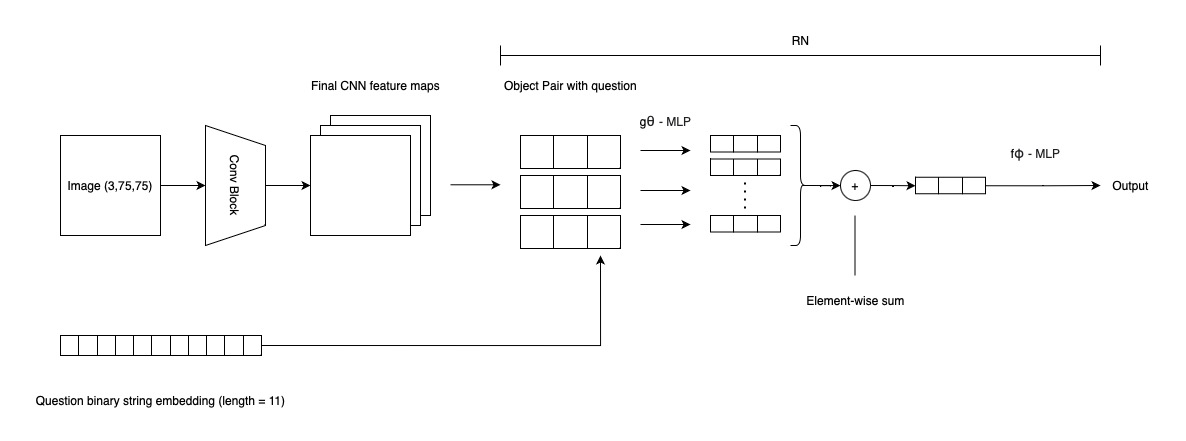

Data flow through the network is as follows:

*Image and Question-Answer feature map:*

1. **Image Feature Maps** are generated using 4 convolutional layers with 32, 64, 128, and 256 kernels with ReLU activation and batch-normalization

2. **Questions and Answers (labels)** are encoded as fixed-length binary strings

*RN:*

3. The questions and the feature maps are passed directly to the RN

3. **Object pairs with questions** (see detailed explanation below) are generated by concatenating questions to the object pairs generated from the CNN feature maps 

4. **Add coordinates position** information for particle image feature

3. **$g_θ$ function**: The questions are passed directly to the RN along side the object pairs to a 4 layer MLP consisting of 2000 units per layer with ReLU activation

3. We apply element-wise sum for the output of $g_θ$ to scale back to the original batch size

4. **$f_ϕ$ function**: The output is passed to a 4 layer MLP consisting of 2000, 1000, 500, and 100 units with ReLU activation

5. The final output linear layer in $f_ϕ$ has a **softmax** activation over the 10 possible answers (answer is a a one-hot vector of size 10)

**Cross entropy loss function** with Adam optimizer is used to train the network.

**Hyperparameters for the network**

- batch_size = 64
- learning_rate = $1e^{-4}$

**Object pairs with questions, for 1 image** 

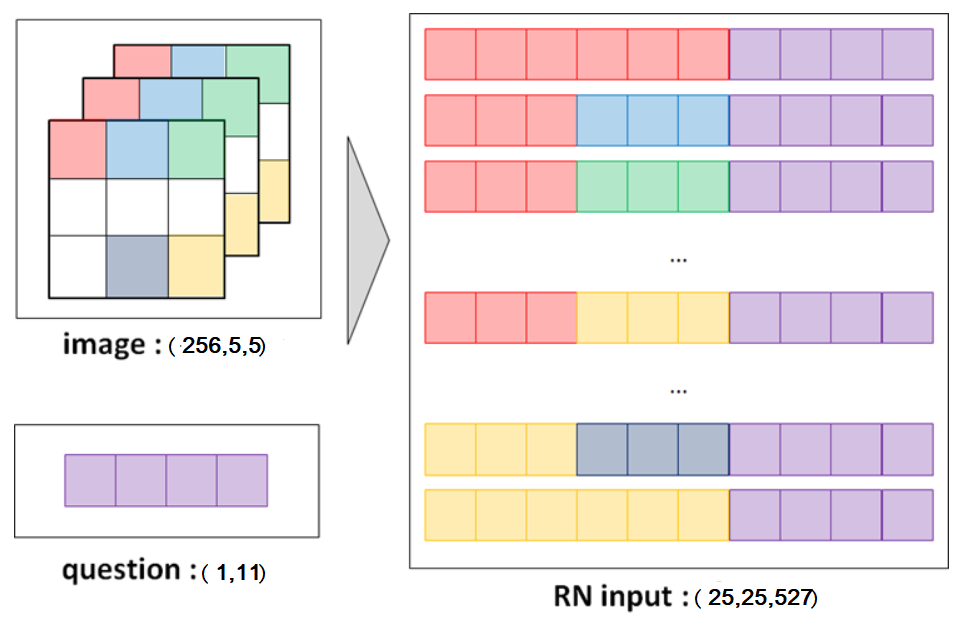

Questions:
- Each question one-hot vector is of size (1,11)

- We add two axes and repeat the questions across one axes, making the dimension (25,1,11)

Feature Map:
- The output feature map for each image is of size (256,5,5)


Object pairs with questions:
- We reshape and add coordinates to the feature map, making the dimension (25, 258)

- From this, create set 1 and set 2 data

- Create set 1: add an axis at loc=0 and repeating pixels across rows: (25, 258) -> (1, 25, 258) -> (25,25,258)

- Create set 2 by adding an axis at loc=1, adding ques of size 11 along that axis and repeating pixels across columns: (25, 258) -> (25, 1, 258) -> (25, 1, 269) -> (25,25,269)

- Finally, concatenate set 1 and set 2 along the last axes, making the dimension (25,25,527), where 

$\quad \quad$ last_dim_size=(2 for each set*(256 features + 2 coordinates)) + 11 ques = 527





In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.autograd import Variable

In [ ]:
"""Generate image feature maps using CNN"""
class ConvBlock(nn.Module):
    def __init__(self):
        super(ConvBlock, self).__init__()
        # CONV input dimention (64,3,75,75) for 64 batch size, Sort-of-CLEVR images size 75 × 75 x 3, we swap the axes to make it to 3 x 75 x 75

        self.conv1 = nn.Conv2d(3, 32, 3, stride=2, padding=1)       # filter input = 3, number of filters = 32 kernels, kernel size = 3
        self.batch_norm1 = nn.BatchNorm2d(32)                       # 2d Batch Normalization with num_features 32
                                                                    # CONV1 output dimention (64,32,38,38)                     

        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)      # filter input = 3, number of filters = 64 kernels, kernel size = 3
        self.batch_norm2 = nn.BatchNorm2d(64)                       # 2d Batch Normalization with num_features 64
                                                                    # CONV2 output dimention (64,64,19,19)

        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)     # filter input = 3, number of filters = 128 kernels, kernel size = 3
        self.batch_norm3 = nn.BatchNorm2d(128)                      # 2d Batch Normalization with num_features128
                                                                    # CONV3 output dimention (64,128,10,10)

        self.conv4 = nn.Conv2d(128, 256, 3, stride=2, padding=1)     # filter input = 3, number of filters = 256 kernels, kernel size = 3
        self.batch_norm4 = nn.BatchNorm2d(256)                      # 2d Batch Normalization with num_features 256
                                                                    # final Conv4 output feature dimention (64,256,5,5)
        

    def forward(self, img):
        # using ReLU activation and Batch Norm after at CONV layer
        x = self.conv1(img)              # img input dimention (64,3,75,75)
        x = F.relu(x)
        x = self.batch_norm1(x)
        
        x = self.conv2(x)                # input dimention (64,32,38,38)
        x = F.relu(x)
        x = self.batch_norm2(x)
        
        x = self.conv3(x)                # input dimention (64,64,19,19)
        x = F.relu(x)
        x = self.batch_norm3(x)
        
        x = self.conv4(x)                # input dimention (64,128,10,10)
        x = F.relu(x)
        x = self.batch_norm4(x)
        
        return x                         # x output feature dimention = (64,256,5,5)
        

In [ ]:
"""Coordination position information"""
# The coordinate position vector is a vector to provide pixel position information
def cvt_coord(i):
    return [(i/5-2)/2., (i%5-2)/2.]                # based on the size of the final CNN feature map (5,5), dividing i by 5
    
def get_coord():
    # For preparing the coord tensor, using dim1 = 25 because the size of the final conv_feature_map is [BS=64,256,5,5]
    # thus forming a 25 object feature map for each image in the mini-batch
    np_coord_tensor = np.zeros((64, 25, 2))
    for i in range(25):
        np_coord_tensor[:,i,:] = np.array(cvt_coord(i))
        
    return np_coord_tensor                         # size of the coord tensor (25,25,2)

In [ ]:
"""f_phi classifier"""
class FCBlock(nn.Module):
  def __init__(self):
    super(FCBlock, self).__init__()
    self.fc1 = nn.Linear(2000, 2000)          # FC layer with in_features 2000, out_features 2000 
    self.fc2 = nn.Linear(2000, 1000)          # FC layer with in_features 2000, out_features 1000 
    self.fc3 = nn.Linear(1000, 500)           # FC layer with in_features 1000, out_features 500 
    self.fc4 = nn.Linear(500, 100)            # FC layer with in_features 500, out_features 100 
    self.out = nn.Linear(100, 10)             # FC layer with in_features 100, out_features 10, for 10 possible classes (answer vector size) 
        
  def forward(self, x):
    # using ReLU activation after each FC layer (except the final output FC layer)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    x = F.relu(x)
    x = self.fc3(x)
    x = F.relu(x)
    x = self.fc4(x)
    x = F.relu(x)
    x = self.out(x)
    # no softmax activation required for the final FC layer, since PyTorch Cross Entropy takes in logits as inputs
    
    return x                         # x out_features dimention = 10, for 10 possible classes (answer vector size)

In [ ]:
class RN(nn.Module):
    def __init__(self, batch_size=64):
        super(RN, self).__init__()
        # Define the parameters for the RN network
        self.name = 'RN'

        """Generate feature maps using CNN"""
        # Conv block to generate CNN feature map for each image
        self.conv = ConvBlock()                                  # final Conv output feature dimentions (64,256,5,5)
        
        """g_theta DNN"""
        self.g_fc1 = nn.Linear((256+2)*2+11, 2000)         # g_fc1 input dim = ((num of filters per object + 2 coord.)*2) + question vector
        self.g_fc2 = nn.Linear(2000, 2000)                 # FC layer with in_features 2000, out_features 2000 
        self.g_fc3 = nn.Linear(2000, 2000)                 # FC layer with in_features 2000, out_features 2000 
        self.g_fc4 = nn.Linear(2000, 2000)                 # FC layer with in_features 2000, out_features 2000 
        
        """f_phi classifier"""
        self.fcout = FCBlock()                             # set of 4 FC layers with first in_features 2000, final out_features 10 for 10 classes
        
        """Coordination position information"""
        # prepare coord tensor
        self.coord_oi = Variable(torch.FloatTensor(batch_size, 2).cuda()) 
        self.coord_oj = Variable(torch.FloatTensor(batch_size, 2).cuda())
        
        # For preparing the coord tensor, using dim1 = 25 because the size of the final conv_feature_map is [BS=64,256,5,5]
        # thus forming a 25 object feature map for each image in the mini-batch
        self.coord_tensor = Variable(torch.FloatTensor(64, 25, 2).cuda())
        self.coord_tensor.data.copy_(torch.from_numpy(get_coord()))
               
        # using adam optimizer with learning rate 0.0001
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)
            
    def forward(self, img, ques):
        """Generate feature maps for each image"""
        x = self.conv(img)                             # x dimension (64 batch, 256 channels, 5,5) 

        # define parameters
        mb = x.size()[0]                               # instead of using for loops, accessing objects for g_theta in a vectorized manner, mb = 64
        n_channels = x.size()[1]                       # num_channels = 256
        d = x.size()[2]                                # d = 5

        """Add coordination position information"""
        # x.view(mb, n_channels, d*d) dimension = (64, 256, 25)
        x_flat = x.view(mb, n_channels, d*d).permute(0,2,1)         # x_flat dimension = (64, 25, 256), after permute to change axes
        x_flat = torch.cat([x_flat, self.coord_tensor], 2)          # x_flat dimension = (64, 25, 258), add coordinates

        """Generate object pair with questions"""
        # add question everywhere
        # initial ques dimension =  (64 bs, 11 que_size)
        ques = torch.unsqueeze(ques, 1)                 # ques dimension = (64,1,11), adding another ax at loc = 1
        ques = ques.repeat(1, 25, 1)                    # ques dimension = (64,25,11), repeating ques across dim 1
        ques = torch.unsqueeze(ques, 2)                 # ques dimension = (64,25,1,11), adding another ax at loc = 2
        
        # cast all possible pairs of the image feature maps against each other, concatenate the question features to them
        # x_flat dimension = (64, 25, 258)
        x_i = torch.unsqueeze(x_flat, 1)                # x_i dimension = (64,1,25,258), adding another ax to x_flat at loc = 1
        x_i = x_i.repeat(1, 25, 1, 1)                   # x_i dimension = (64,25,25,258), copying / repeating pixels across rows (dim 1)

        x_j = torch.unsqueeze(x_flat, 2)                # x_j dimension = (64,25,1,258), adding another ax to x_flat at loc = 2
        x_j = torch.cat([x_j, ques], 3)                 # x_j dimension = (64,25,1,269), adding ques of size 11 along ax=3 => dim3_size=258+11=269
        x_j = x_j.repeat(1, 1, 25, 1)                   # x_j dimension = (64,25,25,269), copying / repeating pixels across columns (dim 2)
        
        # concatenate all together
        x_full = torch.cat([x_i, x_j], 3)               # x_full dimension = (64,25,25,527), concat x_i, x_j along ax=3 => dim3_size=(2*258)+11=527
        
        # reshape for passing through g_theta network
        x_ = x_full.view(mb * (d*d) * (d*d), 527)       # x_ dimension = (64*25*25, 527) = (40000, 527)
            
        """g_theta"""
        # pass through 4 layers MLP for function g_theta, use ReLU activation after each fc layer
        x_ = self.g_fc1(x_)
        x_ = F.relu(x_)
        x_ = self.g_fc2(x_)
        x_ = F.relu(x_)
        x_ = self.g_fc3(x_)
        x_ = F.relu(x_)
        x_ = self.g_fc4(x_)
        x_ = F.relu(x_)
        
        # reshape and sum for passing through f_phi network
        x_g = x_.view(mb, (d*d) * (d*d), 2000)           # x_g dimension = (64,25*25,2000) = (64,625,2000), dim3=2000 since next f_fc1 is of size 2000
        # the first dimension was inflated 625 times more than the original batch size when we created new object pairs
        # hence we compute the element-wise sum to scale back to the original batch size
        x_g = x_g.sum(1).squeeze()                       # x_g dimension = (64,1,2000), after element wise sum across ax=1
        

        """f_phi"""
        # pass through the four layers MLP for function f_phi and return the class probabilities predictions
        return self.fcout(x_g)
        
    def train_(self, img, ques, label):
        self.optimizer.zero_grad()
        output = self(img, ques)
        loss = F.cross_entropy(output, label)                 # using cross entropy loss
        loss.backward()
        pred = output.data.max(1)[1]                          # predicting class probabilities
        correct = pred.eq(label.data).cpu().sum()             
        accuracy = correct * 100. / len(label)                # calculating accuracy
        return accuracy, loss
        
    def test_(self, img, ques, label):
        output = self(img, ques)
        loss = F.cross_entropy(output, label)                 # using cross entropy loss
        pred = output.data.max(1)[1]                          # predicting class probabilities
        correct = pred.eq(label.data).cpu().sum()
        accuracy = correct * 100. / len(label)                # calculating accuracy
        return accuracy, loss
        
    def save_model(self, epoch):
        torch.save(self.state_dict(), f"{self.name}_{epoch}.pth")      # saving the model using torch.save

In [ ]:
model = RN()
model

RN(
  (conv): ConvBlock(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(24, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(24, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(24, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch_norm4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (g_fc1): Linear(in_features=527, out_features=2000, bias=True)
  (g_fc2): Linear(in_features=2000, out_features=2000, bias=True)
  (g_fc3): Linear(in_features=2000, out_features=2000, bias=True)
  (g_fc4): Linear(in_features=2000, out_features=2000, bias